<!-- Do NOT edit the Markdown file directly - generated from the Jupyter notebook. -->

# Tumoroscope in PyMC

[![python](https://img.shields.io/badge/Python-3.9+-3776AB.svg?style=flat&logo=python&logoColor=white)](https://www.python.org)
[![Pytest](https://github.com/jhrcook/tumoroscope-pymc/actions/workflows/pytest.yaml/badge.svg)](https://github.com/jhrcook/tumoroscope-pymc/actions/workflows/pytest.yaml)
[![Code style: black](https://img.shields.io/badge/code%20style-black-000000.svg)](https://github.com/psf/black)
[![pre-commit](https://img.shields.io/badge/pre--commit-enabled-brightgreen?logo=pre-commit&logoColor=white)](https://github.com/pre-commit/pre-commit)
[![Checked with mypy](http://www.mypy-lang.org/static/mypy_badge.svg)](http://mypy-lang.org/)
[![pydocstyle](https://img.shields.io/badge/pydocstyle-enabled-AD4CD3)](http://www.pydocstyle.org/en/stable/)
[![License: GPLv3](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0)

**This package is a Work-in-Progress.**

This package builds the ['Tumoroscope']() (Shafighi *et al.*, 2022, bioRxiv preprint) model with the probabilistic programming library [PyMC]().
'Tumoroscope' is a "probabilistic model that accurately infers cancer clones and their high-resolution localization by integrating pathological images, whole exome sequencing, and spatial transcriptomics data."

![Tumoroscope diagram](tumoroscope-diagram.jpeg)

## Installation

> As this package provides a model produced using PyMC, I recommend first creating a virtual environment using `conda` and installing the PyMC library.
> You can follow their instructions [here](https://www.pymc.io/projects/docs/en/latest/installation.html).

You can install this package using `pip` either from PyPI

```bash
pip install tumoroscope-pymc  # not available yet
```

or from GitHub

```
pip install git+https://github.com/jhrcook/tumoroscope-pymc.git
```

## Use

Below is a simple example of using this library.
A small dataset is simulated and used to construct the Tumoroscope model in PyMC.
The "Inference Button" of PyMC is then used to sample from the posterior distribution.

In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from tumoroscope import TumoroscopeData, build_tumoroscope_model
from tumoroscope.mock_data import generate_simulated_data

In [2]:
# %matplotlib inline
%config InlineBackend.figure_format='retina'

### Simulated data

In [3]:
TumoroscopeData(
    K=5,
    S=10,
    M=100,
    F=np.ones(5) / 5,
    cell_counts=np.random.randint(1, 20, size=10),
    C=np.random.beta(2, 2, size=(100, 5)),
    D_obs=np.random.randint(2, 20, size=(100, 10)),
    A_obs=np.random.randint(2, 20, size=(100, 10)),
)

Tumoroscope Data
Data sizes:
  K: 5  S: 10  M: 100Hyperparameters:
  zeta_s: 1.0  F_0: 1.0  l: 100  r: 0.1  p: 1.0Counts data:
  D: provided    A: provided  

In [4]:
simulation = generate_simulated_data(
    K=5, S=10, M=50, total_read_rate=2.5, random_seed=8
)
simulation.sim_data.validate()
simulation.true_labels.head()

,spot,cell,clone
0,0,0,2
1,0,1,0
2,0,2,3
3,0,3,1
4,1,0,0


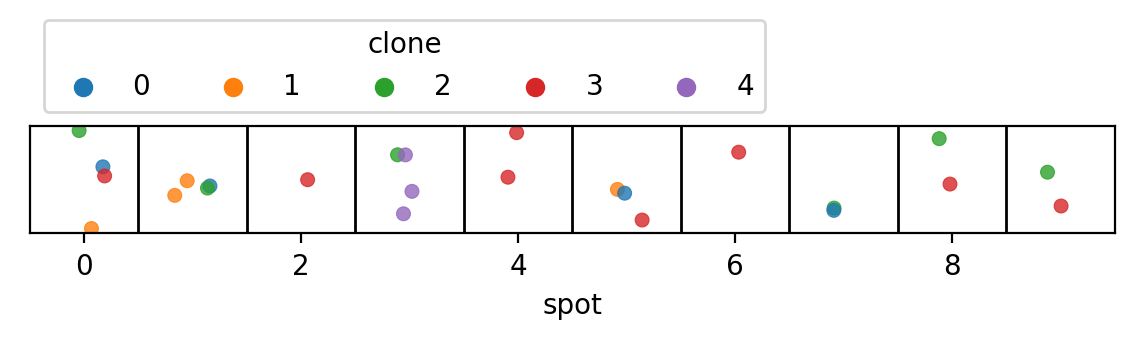

In [5]:
np.random.seed(3)
plot_df = (
    simulation.true_labels.copy()
    .assign(
        y=lambda d: np.random.normal(0, 0.5, len(d)),
        x=lambda d: d["spot"] + np.random.uniform(-0.2, 0.2, len(d)),
    )
    .astype({"clone": "category"})
)
_, ax = plt.subplots(figsize=(7, 0.7))
sns.scatterplot(
    data=plot_df, x="x", y="y", hue="clone", ax=ax, alpha=0.8, edgecolor=None, s=25
)
for i in range(1, simulation.sim_data.S):
    ax.axvline(i - 0.5, lw=1, color="k")
ax.set_xlim(-0.5, simulation.sim_data.S - 0.5)
ax.set_xlabel("spot")
ax.set_ylabel(None)
ax.set_yticks([])
ax.legend(
    loc="lower left", bbox_to_anchor=(0, 1), title="clone", ncol=simulation.sim_data.K
)
plt.show()

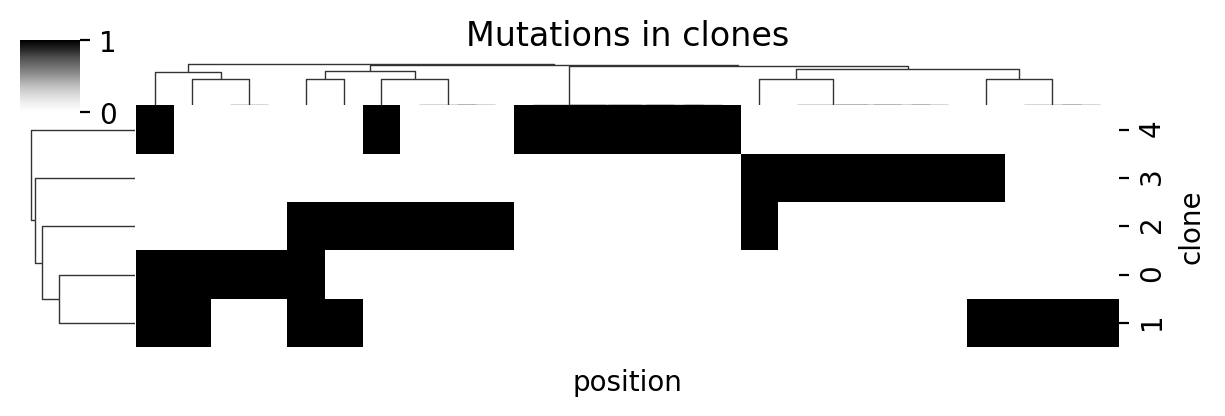

In [6]:
cg = sns.clustermap(
    simulation.clone_mutations.T,
    figsize=(6, 2),
    dendrogram_ratio=(0.1, 0.15),
    cmap="Greys",
)
cg.ax_heatmap.set_xlabel("position")
cg.ax_heatmap.set_ylabel("clone")
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.tick_params("x", size=0)
cg.ax_col_dendrogram.set_title("Mutations in clones")
plt.show()

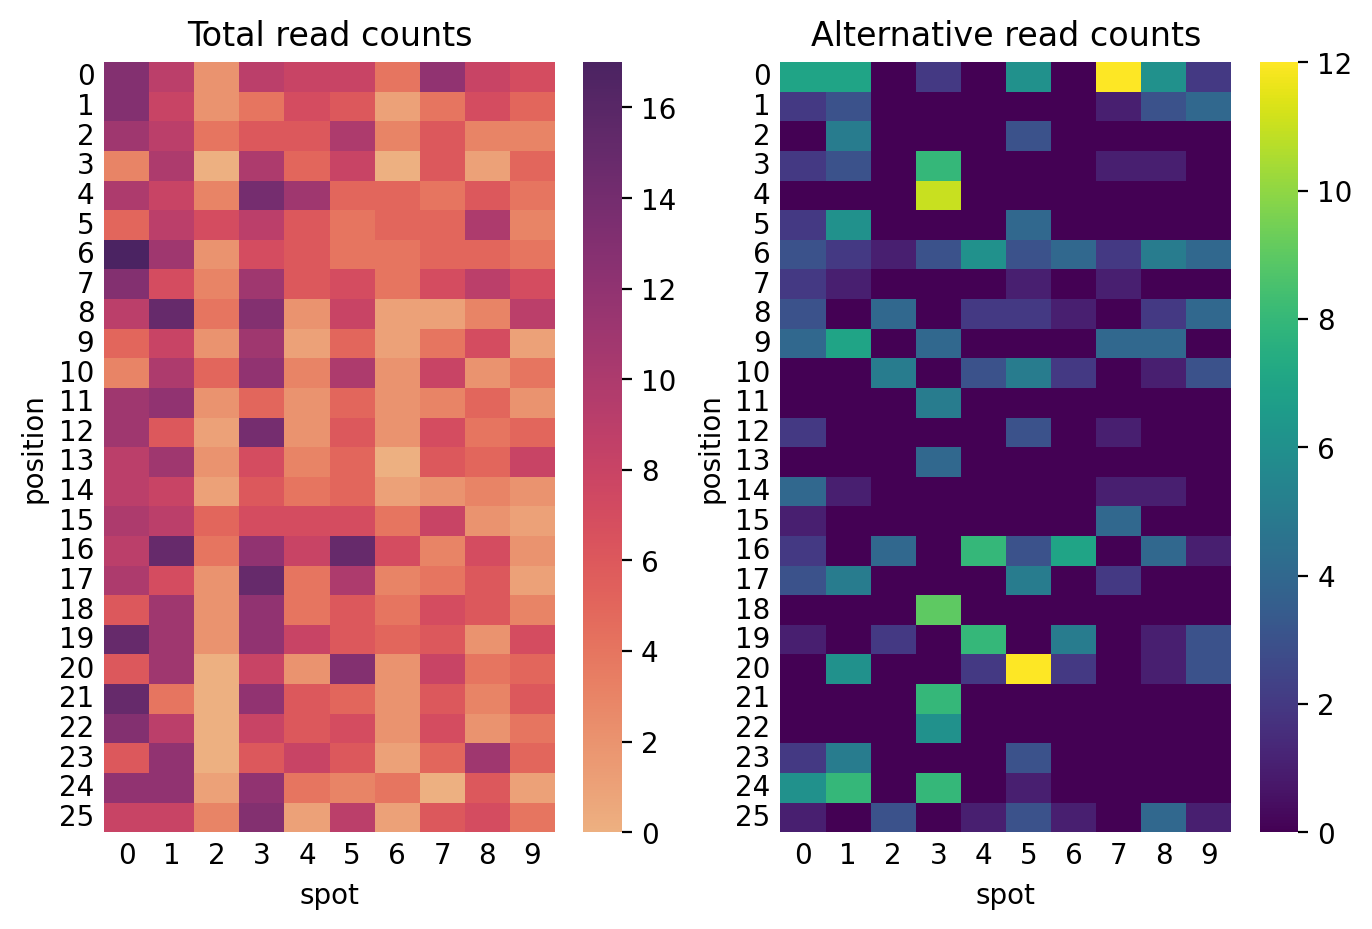

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
sns.heatmap(simulation.sim_data.D_obs, cmap="flare", ax=axes[0])
axes[0].set_title("Total read counts")
sns.heatmap(simulation.sim_data.A_obs, cmap="viridis", ax=axes[1])
axes[1].set_title("Alternative read counts")

for ax in axes:
    ax.tick_params(size=0)
    ax.set_xlabel("spot")
    ax.set_ylabel("position")

plt.show()

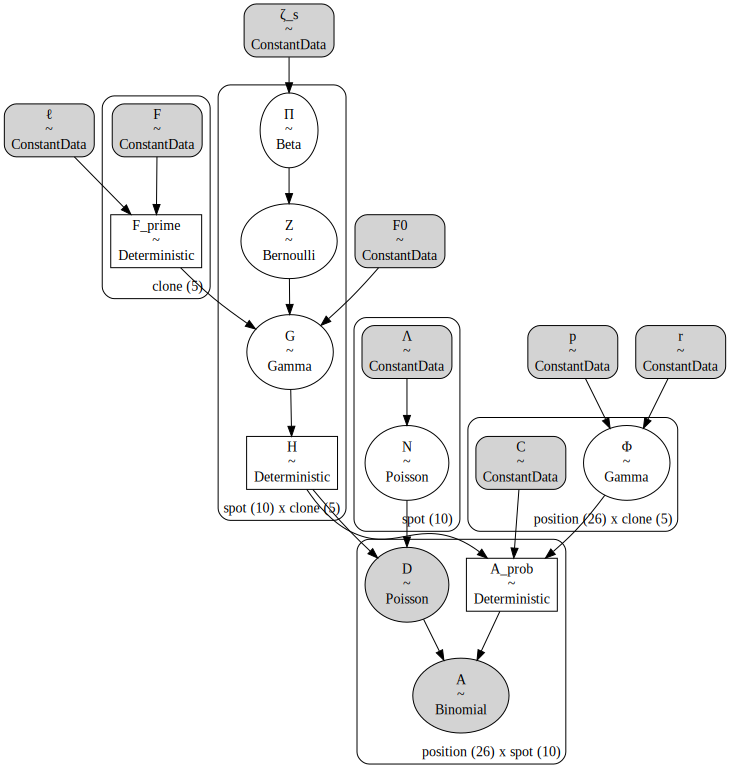

In [8]:
tumoroscope_model = build_tumoroscope_model(simulation.sim_data)
pm.model_to_graphviz(tumoroscope_model)

MCMC runtime was approximately 5 minutes on my computer.

In [9]:
cache_fp = Path(".cache") / "tumoroscope-simulation-example.netcdf"
if not cache_fp.parent.exists():
    cache_fp.parent.mkdir()

if cache_fp.exists():
    print("Retrieving from cache.")
    trace = az.from_netcdf(cache_fp)
else:
    with tumoroscope_model:
        trace = pm.sample(500, tune=500, chains=2, cores=2, random_seed=7)
        _ = pm.sample_posterior_predictive(
            trace, extend_inferencedata=True, random_seed=7
        )
    trace.to_netcdf(cache_fp)

Retrieving from cache.


In [10]:
h_post = az.summary(trace, var_names=["H"])
h_post.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"H[s0, c0]",0.399,0.067,0.281,0.527,0.005,0.004,157.0,412.0,1.00
"H[s0, c1]",0.121,0.051,0.041,0.226,0.004,0.003,199.0,309.0,1.01
"H[s0, c2]",0.267,0.060,0.162,0.379,0.005,0.003,156.0,521.0,1.02
"H[s0, c3]",0.177,0.046,0.092,0.258,0.003,0.002,295.0,561.0,1.01
"H[s0, c4]",0.036,0.033,0.000,0.094,0.002,0.001,315.0,538.0,1.01


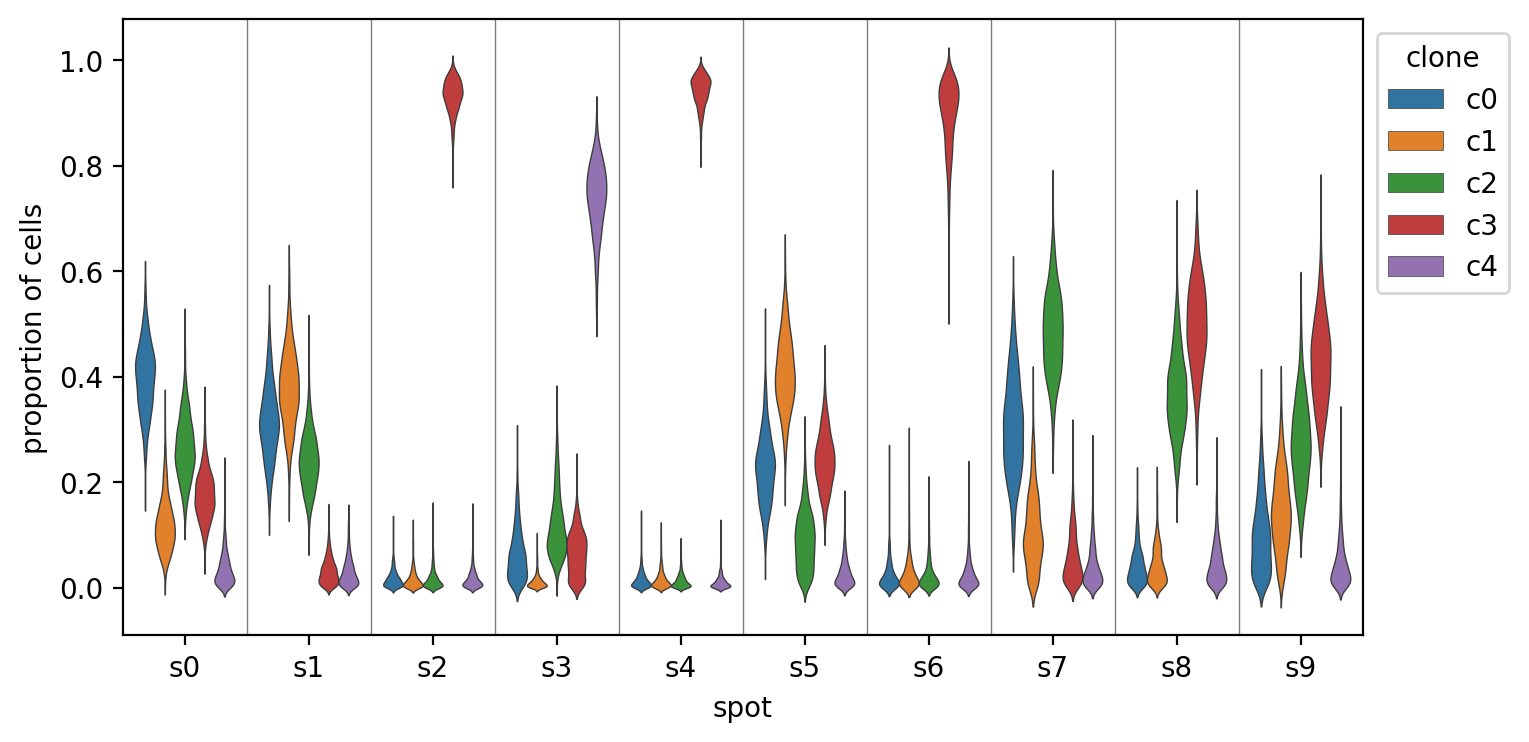

In [11]:
h_post = trace.posterior["H"].to_dataframe().reset_index()
_, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(
    data=h_post,
    x="spot",
    y="H",
    hue="clone",
    dodge=True,
    scale="width",
    inner=None,
    linewidth=0.5,
    ax=ax,
)
for i in range(simulation.sim_data.S):
    ax.axvline(i + 0.5, c="grey", lw=0.5)

ax.set_xlabel("spot")
ax.set_ylabel("proportion of cells")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="clone")
plt.show()

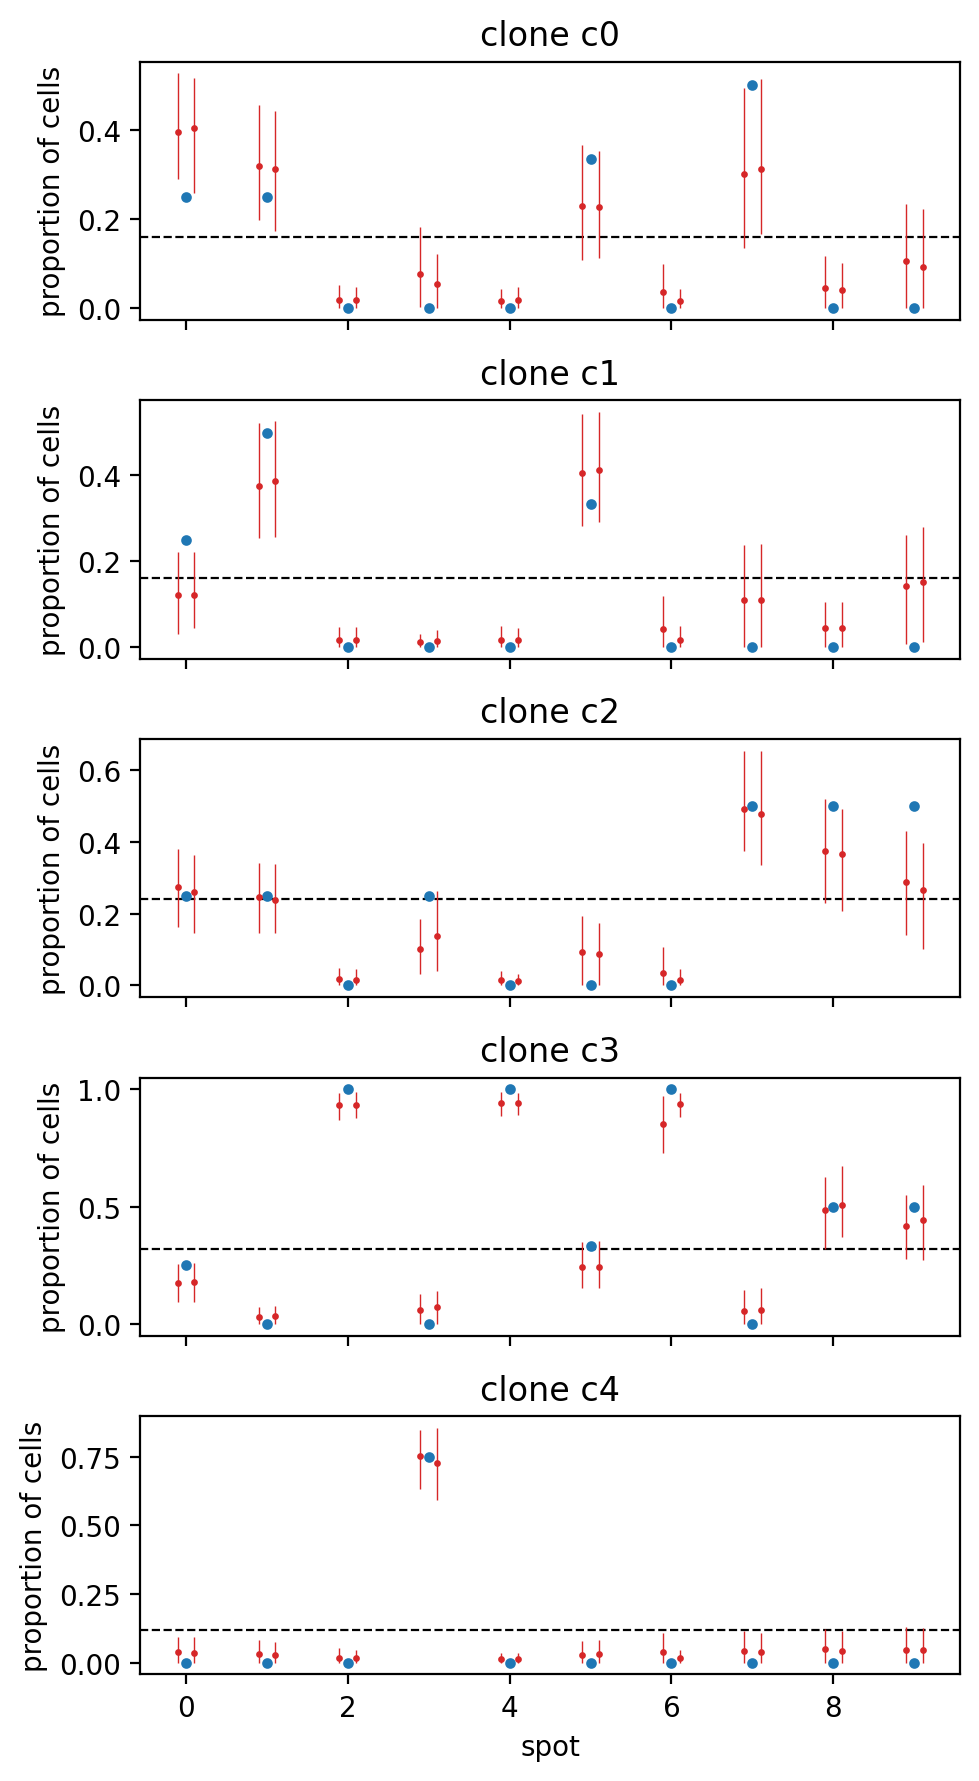

In [12]:
def frac_clone(s: pd.Series, k: int) -> float:
    """Fraction of cells in `s` that are clone `k`."""
    return np.mean(s == k)


fig, axes = plt.subplots(
    nrows=simulation.sim_data.K, figsize=(5, 1.8 * simulation.sim_data.K), sharex=True
)
for clone_i, ax in enumerate(axes.flatten()):
    clone = f"c{clone_i}"
    ax.set_title(f"clone {clone}")

    # Plot true fraction of clones at each spot.
    true_clone_frac = simulation.true_labels.groupby(["spot"])["clone"].apply(
        frac_clone, k=clone_i
    )
    ax.scatter(
        true_clone_frac.index.tolist(),
        true_clone_frac.values.tolist(),
        c="tab:blue",
        s=8,
        zorder=10,
    )

    # Plot population fraction.
    ax.axhline(simulation.sim_data.F[clone_i], lw=0.8, c="k", ls="--")

    # Plot posterior.
    H = trace.posterior["H"].sel(clone=[clone])
    dx = np.linspace(-0.1, 0.1, len(H.coords["chain"]))
    spot = np.arange(simulation.sim_data.S)
    for chain in H.coords["chain"]:
        _x = spot + dx[chain]
        ax.scatter(_x, H.sel(chain=chain).mean(axis=(0)), c="tab:red", s=2, zorder=20)
        _hdi = az.hdi(H, coords={"chain": [chain]})["H"].values.squeeze()
        ax.vlines(
            x=_x, ymin=_hdi[:, 0], ymax=_hdi[:, 1], lw=0.5, zorder=10, color="tab:red"
        )
    ax.set_ylabel("proportion of cells")
    ax.set_xlabel(None)

axes[-1].set_xlabel("spot")
fig.tight_layout()
plt.show()

## Developing

Setup up the develpment envionrment using `conda` (or `mamba`)

```bash
mamba env create -f conda.yaml
conda activate tumoroscope-pymc
```

Run the test suite using `tox`

```bash
tox
```

Build the README documentation by re-executing the `README.ipynb` notebook and converting it to Markdown using the following command

```bash
tox -e readme
```

---

## Environment information


In [13]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-25

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: dev

numpy     : 1.23.4
pandas    : 1.5.1
arviz     : 0.13.0
pymc      : 4.2.2
seaborn   : 0.12.0
matplotlib: 3.6.1

